<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for grading
From more to less important:
+ Code runs
+ Probability of death for each test patient is computed
+ Accuracy of predictions for test patients is provided
+ Nearest neighbor method(s) have been used
+ Accuracy itself
+ Data preparation
+ Class imbalance management
+ Hyperparameter optimization
+ Neat and understandable code, with some titles and comments
+ Improved methods from what we discussed in class (properly explained/justified)

# Loading packages and Data

## Importing relevant modules

We start by loading the relevant modules. In this particular case most of the function used to manage and visualize the data will come from pandas, seaborn, numpy and matplotlib.pyplot. The machine learning algorithms come from the sklearn module while imblearn module focuses particularly in class imbalance for this algorithms. Finally, the time and statistics modules are used in specific cases that will be explained later in the report.

In [17]:
!pip install imblearn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
import statistics
import imblearn

You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

## Loading the Data 

As mentioned above, the data to be analyzed is the database from the MIMIC project. In this particular case, we will load the training data and the test data separately. Likewise, the extra information that contains relevant information of the patients for the prediction is loaded.

- mimic_diagnoses contains information of the comorbidities of the patient

In [19]:
# Training dataset
data_train=pd.read_csv('/Users/macarenacruzceballos/Desktop/Master/Materias/Computational Machine Learning/CM1_materials/Data/Probability of dead data/mimic_train.csv')
data_test = pd.read_csv('/Users/macarenacruzceballos/Desktop/Master/Materias/Computational Machine Learning/CM1_materials/Data/Probability of dead data/mimic_test_death.csv')
data_train.head(3)

#extra info
mimic_diagnoses = pd.read_csv('/Users/macarenacruzceballos/Desktop/Master/Materias/Computational Machine Learning/CM1_materials/Data/Probability of dead data/MIMIC_diagnoses.csv')


# Exploratory Data Analysis

Before we start to process the data, we carry out data exploration. In this way, we can know and understand our data before deciding how to treat it.

In [20]:
print('Our training data containts '+str(data_train.shape[0])+' rows and '+ str(data_train.shape[1]) +
' variables. While our test data contains '+str(data_test.shape[0])+' rows and '+ str(data_test.shape[1])+' variables')


Our training data containts 20885 rows and 44 variables. While our test data contains 5221 rows and 39 variables


It is important to note that both data set differ in the number of variables that they contain. The variables are those realted to the death of the patient. HOSPITAL_EXPIRE_FLAG is the variable we want to predict, while 'DOD', 'DISCHTIME', 'DEATHTIME' and 'LOS' are variables that relate to the time of death of the patient. As we are predicting the event where a patient dies that information should not be taken into account 

In [21]:
data_test_columns = list(data_test.columns)
data_train_columns = list(data_train.columns)
different_variables= []
for i in data_train_columns:
    if i not in data_test_columns:
        different_variables.append(i)
print(different_variables)

['HOSPITAL_EXPIRE_FLAG', 'DOD', 'DISCHTIME', 'DEATHTIME', 'LOS']


From the data below, we notice that we are dealing with both categorical and numerical features. But most importantly, it is important to note that the dates in the dataframe are not stores as dates but as an object.

In [22]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

Another area to take into consideration in the missing values that our dataframe might ot might not have. Our data frame contains several columns with missing values, so it will be important to find a strategy to deal with these missing observations.

In [23]:
data_train.isnull().sum()

HOSPITAL_EXPIRE_FLAG        0
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Min            2187
HeartRate_Max            2187
HeartRate_Mean           2187
SysBP_Min                2208
SysBP_Max                2208
SysBP_Mean               2208
DiasBP_Min               2209
DiasBP_Max               2209
DiasBP_Mean              2209
MeanBP_Min               2186
MeanBP_Max               2186
MeanBP_Mean              2186
RespRate_Min             2189
RespRate_Max             2189
RespRate_Mean            2189
TempC_Min                2497
TempC_Max                2497
TempC_Mean               2497
SpO2_Min                 2203
SpO2_Max                 2203
SpO2_Mean                2203
Glucose_Min               253
Glucose_Max               253
Glucose_Mean              253
GENDER                      0
DOB                         0
DOD                     13511
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME 

In [24]:
data_test.isnull().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_Min        547
MeanBP_Max        547
MeanBP_Mean       547
RespRate_Min      546
RespRate_Max      546
RespRate_Mean     546
TempC_Min         638
TempC_Max         638
TempC_Mean        638
SpO2_Min          551
SpO2_Max          551
SpO2_Mean         551
Glucose_Min        58
Glucose_Max        58
Glucose_Mean       58
GENDER              0
DOB                 0
ADMITTIME           0
Diff                0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS    180
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
dtype: int64

Knowing that we are going to use a machine learning algorithm focused on distance, it is essential to detect the outliers that our database may have, as these can affect the performance of our model. Detecting outliers will also help us know what steps we should take to handle the missing data from our database and help us decide how to scale our data.

<AxesSubplot:>

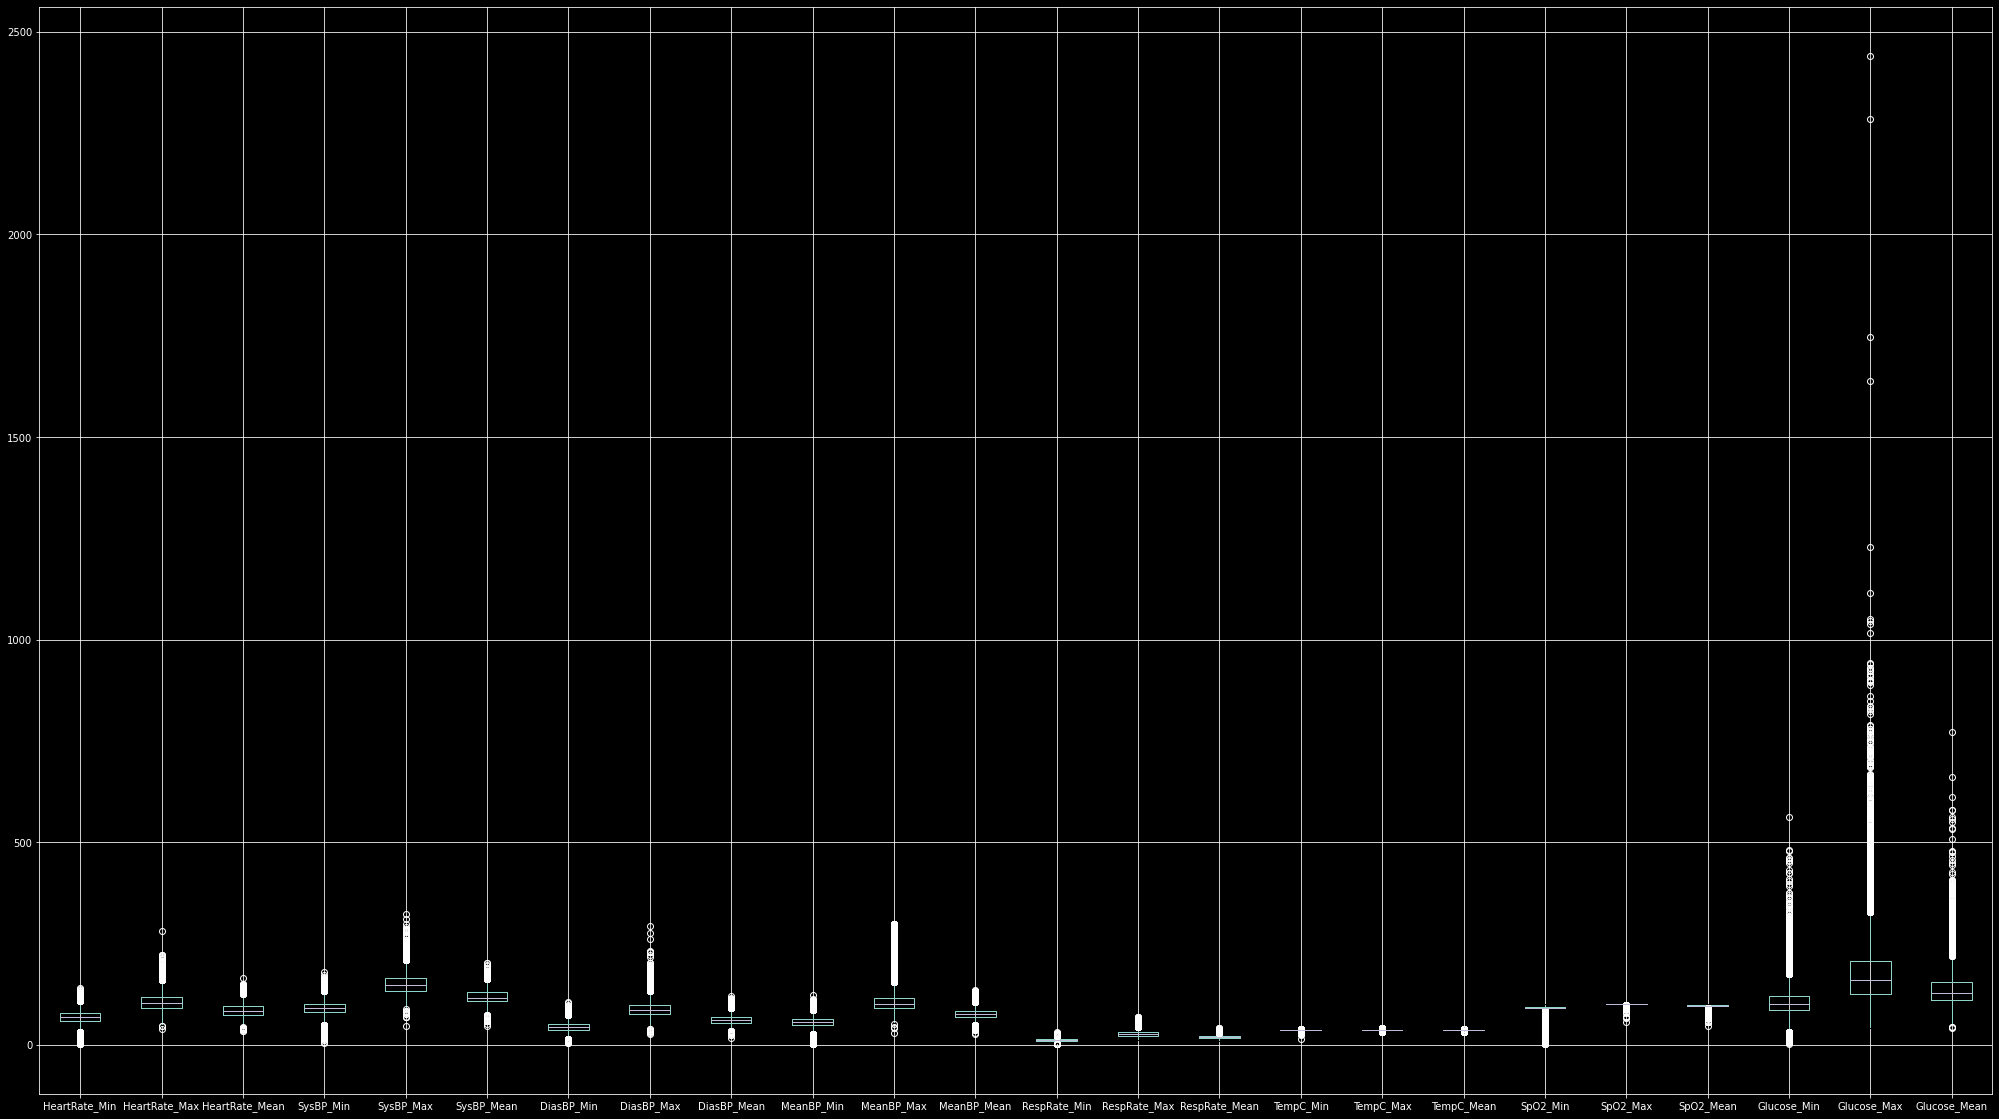

In [25]:
data_train.boxplot(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 
                    'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 
                    'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 
                    'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 
                    'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean'],
                  figsize= (35,20))


As we can see in the previous graph. Medical variables contain observations far from the mean of the column. However, it is essential to mention that they tell us about the patients' health conditions since they are medical variables. Therefore, the points that are far outside the expected values ​​help us detect a health affectation in the patient. It is then necessary to keep these observations in the database.

# Data preprocessing

## Patients age

Since age is a vital factor in health, the first step we will take in preprocessing the database is to calculate the age of the patients through the ADMITTIME and DOB columns.

In [26]:
def age_calc (dataframe):
    # First, we split the columns to have the date and hour in two new columns
    dataframe['DOB year'] = dataframe['DOB'].str.split(' ', expand = True)[0]
    dataframe['DOB time'] = dataframe['DOB'].str.split(' ', expand = True)[1]
    dataframe['ADMITTIME_year']= dataframe['ADMITTIME'].str.split(' ', expand = True)[0]
    dataframe['ADMITTIME_hour']= dataframe['ADMITTIME'].str.split(' ', expand = True)[1]
    # In this case we drop the columns related to time
    dataframe = dataframe.drop(['DOB','ADMITTIME','DOB time','ADMITTIME_hour'],axis=1)
    #Now knowing that this values where stored as objects we convert them to time variables
    dataframe['DOB year'] = pd.to_datetime(dataframe['DOB year']).dt.date
    dataframe['ADMITTIME_year'] = pd.to_datetime(dataframe['ADMITTIME_year']).dt.date
    #Finally we add 'age' column to the dataframe
    dataframe['age'] = dataframe.apply(lambda e: (e['ADMITTIME_year'] - e['DOB year']).days/365, axis=1)
    return dataframe


We may now use the fuction created above in both our dataframes

In [27]:
data_train = age_calc(data_train)
data_test = age_calc(data_test)
data_train.loc[data_train['age'] > 100, 'age']

10       300.200000
13       300.200000
30       300.200000
53       300.200000
56       300.200000
            ...    
20837    300.200000
20844    300.994521
20853    300.200000
20874    300.200000
20883    300.200000
Name: age, Length: 1107, dtype: float64

The DOD and ADMITTIME information contained errors in how they was recorded in the database, so when calculating the age of the patients, there are patients over 100 years old. Given this case, in these observations, age is replaced by the mean age of the patients.

In [28]:
cond= data_train[data_train['age'] < 100]
mean_age = statistics.mean(cond['age'])
data_train.loc[data_train['age'] > 100, 'age'] = mean_age
data_train[data_train['age'] > 100]

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS,DOB year,ADMITTIME_year,age


In [29]:
cond= data_test[data_test['age'] < 100]
mean_age = statistics.mean(cond['age'])
data_test.loc[data_test['age'] > 100, 'age'] = mean_age
data_test[data_test['age'] > 100]

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,DOB year,ADMITTIME_year,age


## Comorbidities

Most of the patients admitted to the ICU had several diseases coinciding. We will refer to these co-occurring diseases as comorbidities. To increase the accuracy of our prediction, we must include the occurrence of these diseases in our model.

In [30]:
mimic_diagnoses.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


The first step is to merge the extra data(mimic_diagnoses) and the data_train to observe the number of comorbidities that each pacient had during every ICU stay.

In [31]:
mimic_diagnoses.columns = mimic_diagnoses.columns.str.lower()
data_train_merge1 = pd.merge(data_train,mimic_diagnoses,how='left',on=['hadm_id','subject_id'])
data_train_merge1.columns = data_train_merge1.columns.str.lower()
data_train_merge1.head()

,hospital_expire_flag,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,...,ethnicity,diagnosis,icd9_diagnosis,first_careunit,los,dob year,admittime_year,age,seq_num,icd9_code
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,2108-07-16,2178-02-06,69.608219,1.0,5789
1,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,2108-07-16,2178-02-06,69.608219,2.0,51881
2,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,2108-07-16,2178-02-06,69.608219,3.0,41071
3,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,2108-07-16,2178-02-06,69.608219,4.0,42831
4,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,2108-07-16,2178-02-06,69.608219,5.0,42732


On our merged data we calculate the lethality of every comorbidity and insert this information on our merged data as a new column

In [34]:
mean_mortality=data_train_merge1.groupby('icd9_code').mean()['hospital_expire_flag']
data_train_merge1 ['icd9_code'] = data_train_merge1['icd9_code'].replace(to_replace=mean_mortality.index, value=mean_mortality.values)


Once we added this column we can calculate the mean, min and max of the lethality of every comorbidity per ICU stay. Then we add this information as new columns in the data_train dataframe

In [35]:
max_mortality = data_train_merge1.groupby('hadm_id')['icd9_code'].max()
min_mortality = data_train_merge1.groupby('hadm_id')['icd9_code'].min()
avg_mortality = data_train_merge1.groupby('hadm_id')['icd9_code'].mean()
data_train ['min_mortality'] = data_train['hadm_id'].replace(to_replace=min_mortality.index, value=min_mortality.values)
data_train ['max_mortality'] = data_train['hadm_id'].replace(to_replace=max_mortality.index, value=max_mortality.values)
data_train ['avg_mortality'] = data_train['hadm_id'].replace(to_replace=avg_mortality.index, value=avg_mortality.values)

Know to make our data_train and data_test contain the same information we add the lethality of the comorbidites relating to the unique ICU stay. However, we do not have that information for every unique ICU stay (hadm_id) in the data_test, therefore in those cases we will treat this observations as missing data

In [36]:
data_test ['min_mortality'] = data_test['hadm_id'].replace(to_replace=min_mortality.index, value=min_mortality.values)
data_test ['max_mortality'] = data_test['hadm_id'].replace(to_replace=max_mortality.index, value=max_mortality.values)
data_test ['avg_mortality'] = data_test['hadm_id'].replace(to_replace=avg_mortality.index, value=avg_mortality.values)

data_test['min_mortality'] = np.where(data_test['min_mortality'] >1, np.NaN, data_test['min_mortality'])
data_test['max_mortality'] = np.where(data_test['max_mortality'] >1, np.NaN, data_test['max_mortality'])
data_test['avg_mortality'] = np.where(data_test['avg_mortality'] >1, np.NaN, data_test['avg_mortality'])
data_test

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,DOB year,ADMITTIME_year,age,min_mortality,max_mortality,avg_mortality
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU,2114-08-07,2196-02-23,81.602740,NaN,NaN,NaN
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,WHITE,HYPERGLYCEMIA,25013,MICU,2055-06-04,2103-10-22,48.413699,NaN,NaN,NaN
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,WHITE,KIDNEY STONES/SDA,5920,MICU,2073-04-21,2115-06-28,42.210959,NaN,NaN,NaN
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,WHITE,RIGHT FEMUR FRACTURE,82120,CCU,2078-04-14,2162-08-01,84.353425,NaN,NaN,NaN
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU,2050-01-17,2103-01-16,53.030137,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,...,WHITE,MEDIASTINAL MASS,20152,SICU,2085-07-03,2144-07-16,59.073973,0.000000,0.306069,0.130162
5217,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,4241,CSRU,2067-01-25,2143-03-28,76.219178,0.072072,0.690616,0.158032
5218,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,...,WHITE - RUSSIAN,SMALL BOWEL OBSTRUCTION;SEPSIS,34839,MICU,2020-12-16,2102-04-03,81.347945,NaN,NaN,NaN
5219,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,...,WHITE,CORONARY ARTERY DISEASE\AORTIC VALVE / ASCENDI...,41401,CSRU,2059-07-26,2138-05-19,78.865753,NaN,NaN,NaN


## Death probability per month

We will now add a column to include the probability of dying per month. The reasoninig behind adding this column comes from seasonality. There are certain season in the year where people are prone to disease or accidents. For instance, colder weather have positive correlation to respiratory diseases. Hence, adding seasonality to our model is relevant for our analysis.

In [37]:
data_train['ADMITTIME_year']= pd.to_datetime(data_train['ADMITTIME_year'])
data_train['day'] = data_train['ADMITTIME_year'].dt.day
data_train['month'] = data_train['ADMITTIME_year'].dt.month
data_train['year'] = data_train['ADMITTIME_year'].dt.year
prob_month=data_train.groupby('month').mean()['HOSPITAL_EXPIRE_FLAG']
data_train['month'] = data_train['month'].replace(to_replace=prob_month.index, value=prob_month.values)
data_train = data_train.drop(['DOB year','ADMITTIME_year','day','year'],1)

/var/folders/r6/fwmtwy812cj4fm25hk3j2j8c0000gn/T/ipykernel_5013/649050774.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train = data_train.drop(['DOB year','ADMITTIME_year','day','year'],1)


In [38]:
data_test['ADMITTIME_year']= pd.to_datetime(data_test['ADMITTIME_year'])
data_test['day'] = data_test['ADMITTIME_year'].dt.day
data_test['month'] = data_test['ADMITTIME_year'].dt.month
data_test['year'] = data_test['ADMITTIME_year'].dt.year
data_test['month'] = data_test['month'].replace(to_replace=prob_month.index, value=prob_month.values)
data_test = data_test.drop(['DOB year','ADMITTIME_year','day','year'],1)

/var/folders/r6/fwmtwy812cj4fm25hk3j2j8c0000gn/T/ipykernel_5013/409230107.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_test = data_test.drop(['DOB year','ADMITTIME_year','day','year'],1)


## Multiple ICU stays 

We will now add a column for having multiple stays in the ICU. The reason behind adding this column is that patients that have more than one stay in the ICU might have underlying conditions that might signify weaker health or severe health conditions.

In [39]:
icu_reentries = data_train.groupby('subject_id').count()
data_train ['icu_reentries'] = data_train['subject_id'].replace(to_replace=icu_reentries.index, value=icu_reentries.values)
max_reentries = data_train ['icu_reentries'].max()
max_reentries

25

In [40]:
data_test['icu_reentries'] = data_test['subject_id'].replace(to_replace=icu_reentries.index, value=icu_reentries.values+1)
data_test['icu_reentries'] = np.where(data_test['icu_reentries'] >max_reentries, 1, data_test['icu_reentries'])
data_test

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age,min_mortality,max_mortality,avg_mortality,month,icu_reentries
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU,81.602740,NaN,NaN,NaN,0.126777,1
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,WHITE,HYPERGLYCEMIA,25013,MICU,48.413699,NaN,NaN,NaN,0.113861,1
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,WHITE,KIDNEY STONES/SDA,5920,MICU,42.210959,NaN,NaN,NaN,0.111173,1
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,WHITE,RIGHT FEMUR FRACTURE,82120,CCU,84.353425,NaN,NaN,NaN,0.114799,1
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU,53.030137,NaN,NaN,NaN,0.122668,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,...,WHITE,MEDIASTINAL MASS,20152,SICU,59.073973,0.000000,0.306069,0.130162,0.089418,7
5217,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,4241,CSRU,76.219178,0.072072,0.690616,0.158032,0.121135,1
5218,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,...,WHITE - RUSSIAN,SMALL BOWEL OBSTRUCTION;SEPSIS,34839,MICU,81.347945,NaN,NaN,NaN,0.117711,1
5219,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,...,WHITE,CORONARY ARTERY DISEASE\AORTIC VALVE / ASCENDI...,41401,CSRU,78.865753,NaN,NaN,NaN,0.094639,1


# Categorical observations

When dealing with categorical observations, one must decide how to include them in the model or whether to include them or not. For our analysis we will include these variables. For example, characteristics like religion directly affect the treatments they can or cannot help for patients. This is just an example of the importance of including categorical variables in our model. The reason behind using target enconding vs Onehotenconder was dimensionality. Using onehotenconder for variables like religion would have meant adding one column per religion. Some religions have very few believers, creating columns with a large number of zeros and very few significant observations. While when using target encoding, we keep almost the original size of data frame, therefore outweighing the benefits of onehoteconder 

In [41]:
def target_encoding(dataframe_train, dataframe_test,categorical):
    for cate in categorical:
        mean_data=dataframe_train.groupby(cate).mean()['HOSPITAL_EXPIRE_FLAG']
        dataframe_train [cate] = dataframe_train[cate].replace(to_replace=mean_data.index, value=mean_data.values)
        dataframe_test [cate] = dataframe_test[cate].replace(to_replace=mean_data.index, value=mean_data.values)
    return (dataframe_train,dataframe_test)
    
categorical_feat = ['GENDER', 'ADMISSION_TYPE','INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT','ICD9_diagnosis']
encoding = target_encoding(data_train,data_test,categorical_feat)
data_train= encoding[0]
data_test = encoding[1]

**The next steps will be explained and justified in this section, however, they will be processed in a pipeline afeter creating values x and y for our model**

# Handling Missing Data

As mentioned before our dataframe contains missing values. In order to manage this missign values we must identify why the value is missing. There are 3 broad categories of missing values Missing Completely At Random, Missing At Random and Missing Not At Random.

In [42]:
Nulls = data_train.isnull().sum()
print(Nulls)

HOSPITAL_EXPIRE_FLAG        0
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Min            2187
HeartRate_Max            2187
HeartRate_Mean           2187
SysBP_Min                2208
SysBP_Max                2208
SysBP_Mean               2208
DiasBP_Min               2209
DiasBP_Max               2209
DiasBP_Mean              2209
MeanBP_Min               2186
MeanBP_Max               2186
MeanBP_Mean              2186
RespRate_Min             2189
RespRate_Max             2189
RespRate_Mean            2189
TempC_Min                2497
TempC_Max                2497
TempC_Mean               2497
SpO2_Min                 2203
SpO2_Max                 2203
SpO2_Mean                2203
Glucose_Min               253
Glucose_Max               253
Glucose_Mean              253
GENDER                      0
DOD                     13511
DISCHTIME                   0
DEATHTIME               18540
Diff                        0
ADMISSION_

In [43]:
data_train.isnull().mean().sort_values(ascending=False)

DEATHTIME               0.887718
DOD                     0.646924
TempC_Mean              0.119559
TempC_Max               0.119559
TempC_Min               0.119559
DiasBP_Min              0.105770
DiasBP_Max              0.105770
DiasBP_Mean             0.105770
SysBP_Min               0.105722
SysBP_Max               0.105722
SysBP_Mean              0.105722
SpO2_Mean               0.105482
SpO2_Max                0.105482
SpO2_Min                0.105482
RespRate_Min            0.104812
RespRate_Max            0.104812
RespRate_Mean           0.104812
HeartRate_Min           0.104716
HeartRate_Mean          0.104716
HeartRate_Max           0.104716
MeanBP_Mean             0.104668
MeanBP_Max              0.104668
MeanBP_Min              0.104668
MARITAL_STATUS          0.034570
Glucose_Min             0.012114
Glucose_Max             0.012114
Glucose_Mean            0.012114
max_mortality           0.000000
ETHNICITY               0.000000
min_mortality           0.000000
avg_mortal

As per the table above, medical data has the larger proportion of missing values.Although Deathtime and DOD have larger number of missing values the reason behind this is simply because not al patients in ICU died.

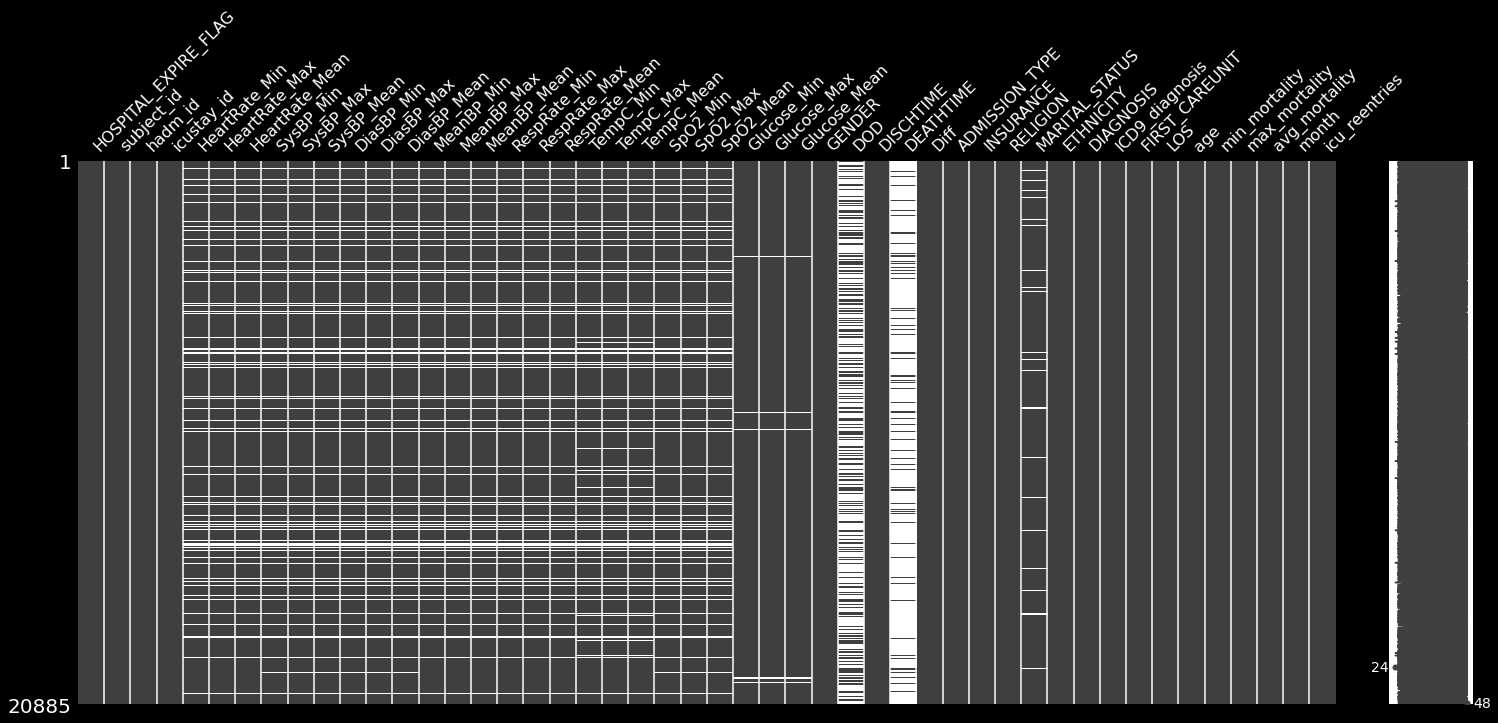

In [44]:
import missingno as msno
msno.matrix(data_train);

The matrix shows how null values are scattered across the data set. The missing values for Glucose_Min Max and Mean, although missing in the same row, have very small proportion of missing values and given that they are scattered completly randomly across the data set can be considered MCAR. However, there seems to be a correlation in the missing values for all medical values apart from Glucose leading to a conclusion that this are MNAR. For this reason, we will use an **IterativeImputer**, that although is more computationally expensive it is more robust. 

By default IterativeImputer employees a BayesianRidge model and features are filled in ascending order

## Handling Imbalance 

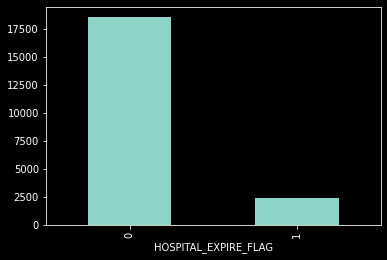

In [45]:
data_train.groupby('HOSPITAL_EXPIRE_FLAG').size().plot.bar()
plt.show()

As per the graph it is very clear that our dataframe is unbalanced, where the minority class is those who died. Therefore we will resample our dataset. We will use the SMOTE algorithm. It aims to balance class distribution by randomly increasing minority class examples by replicating them. 

The next steps in our process are dropping the columns that will no be part of our model. That in these case are DIAGNOSIS and Diff. Mainly because this two features are part of other variables that already for part of our model

In [46]:
data_train = data_train.drop(['DIAGNOSIS','Diff',],1)



/var/folders/r6/fwmtwy812cj4fm25hk3j2j8c0000gn/T/ipykernel_5013/3032055369.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train = data_train.drop(['DIAGNOSIS','Diff',],1)


In [47]:
data_test = data_test.drop(['DIAGNOSIS','Diff',],1)

/var/folders/r6/fwmtwy812cj4fm25hk3j2j8c0000gn/T/ipykernel_5013/1109687078.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_test = data_test.drop(['DIAGNOSIS','Diff',],1)


Finally we create both X and Y, and drop the variables that are not contained in the data_test

In [48]:
X_train = data_train.drop('HOSPITAL_EXPIRE_FLAG',axis = 1)
y = data_train['HOSPITAL_EXPIRE_FLAG']


In [49]:
X_train = X_train[(data_test.columns)]
X_train.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,MARITAL_STATUS,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT,age,min_mortality,max_mortality,avg_mortality,month,icu_reentries
0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,...,0.081218,0.110177,0.097436,0.139468,69.608219,0.086614,0.298851,0.130240,0.126777,1
1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,...,0.111755,0.110177,0.000000,0.139468,42.101370,0.000000,0.151316,0.059211,0.126777,1
2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,...,0.108333,0.092059,0.200000,0.139468,68.210959,0.065934,0.308642,0.173482,0.109973,1
3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,...,0.137637,0.110177,0.000000,0.116637,74.961644,0.078550,0.250000,0.118326,0.122668,2
4,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.137637,0.110177,0.020408,0.106994,79.424658,0.078915,0.202703,0.131693,0.094639,1


As mentioned before in the next step we will create a pipeline that preprocess the data and handles unbalanced data with the algorithms mentioned before 

In [50]:
from imblearn.over_sampling import SMOTE
numerical = X_train.select_dtypes(include=np.number).columns
categorical = X_train.select_dtypes(include=['object']).columns


numeric_transformer = Pipeline(steps=[
       ('imputer', IterativeImputer(missing_values=np.nan))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
])
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numerical)
   ,('categorical', categorical_transformer, categorical)
]) 
pipeline_prep = Pipeline(steps=[('preprocessor',preprocessor)])

oversample = SMOTE()


x_train_p = pipeline_prep.fit_transform(X_train)


x_s,y_s = oversample.fit_resample(x_train_p,y)



# KNN model

We will run a K Nearest Neibourghs model for classification. To identify the optimal parameters of ou model we will refer to a technique called GridSearch. The conventional number of folds selected for a cross validation process is 10, therefore, we will select that value of folds. As the name of the model clearly implies it, the choice of K is a crucial parameter to chose. A conventional value for K is the $sqr(k)$. Therefore by we will start the range of K neighbors at 100. 
Furthermore, as we did not add dummy columns to our dataset we might add to our list of algorithms 'ball_tree' and 'kd_tree'
Finally, as KNN calculates the distance of a new data point to all other training data points, a good parameter to include to the analysis is metric. 

We will try with the most commonly used metrics, euclidean, manhattan and chebyshev as we have a large number of dimensions

In [51]:
range_p = list(range(100,500,50))
parameteres = {'n_neighbors':range_p,'weights':['uniform','distance'],'algorithm':['auto','brute','ball_tree','kd_tree'],'metric':['euclidean','manhattan','chebyshev']}


In [52]:
my_model  = GridSearchCV(KNeighborsClassifier(), param_grid = parameteres,scoring = 'roc_auc', cv=10, n_jobs = -1,verbose=3) 

In [53]:
my_model.fit(x_s,y_s)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[CV 1/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.956 total time= 5.2min
[CV 5/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.967 total time= 5.2min
[CV 2/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.970 total time= 5.2min
[CV 3/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.966 total time= 5.2min
[CV 7/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.965 total time= 5.2min
[CV 4/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.971 total time= 5.2min
[CV 6/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.971 total time= 5.2min
[CV 8/10] END algorithm=auto, metric=euclidean, n_neighbors=100, weights=uniform;, score=0.974 total time= 5.2min
[CV 1/10] END algorithm

KeyboardInterrupt: 

In [33]:
print(my_model.best_estimator_.n_neighbors)
print(my_model.best_estimator_.weights)
print(my_model.best_estimator_.algorithm)
print(my_model.best_estimator_.metric)
print(my_model.best_score_)

NameError: name 'my_model' is not defined

In [ ]:
data_test_s = pipeline_prep.transform(data_test)
ypred=my_model.predict(data_test_s)

In [ ]:
y_pred=my_model.predict_proba(data_test_s)

## Rebalancing the model and generating the predictions

Note that these are not proper estimates of the class probability: we need to correct for the biased sample by rescaling the predicted probability

In [ ]:
q1 = y.sum()/len(y)
r1 = y_s.sum()/len(y_s)
print(q1,r1)

def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

kaggle_test = data_test[['icustay_id']].astype(int)
kaggle_test['HOSPITAL_EXPIRE_FLAG'] = y_pred[:,1]
kaggle_test['HOSPITAL_EXPIRE_FLAG'] = kaggle_test['HOSPITAL_EXPIRE_FLAG'] .apply(reweight,args=(q1,r1))
kaggle_test.head()

0.11228154177639454 0.5


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.010988
1,251754,0.062009
2,242171,0.022723
3,263035,0.149967
4,279388,0.052905


# Assesing the model
To assess the model we will use the evaluation metrics from the sklearn module. In order to access the model we will construct a test and train set from the original data_train.

The evaluation metrics we will lok at are following:
- accuracy score - the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
- precision score - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- recall score - The recall is intuitively the ability of the classifier to find all the positive samples.
- f1 score - The F1 score can be interpreted as a harmonic mean of the precision and recall

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train_p, y, random_state=42)

In [ ]:
insample_y_pred_acc = my_model.predict(X_train)

# Compute different Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

print('Accuracy Score : ' + str(accuracy_score(y_train,insample_y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_train,insample_y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_train,insample_y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_train,insample_y_pred_acc)))

Accuracy Score : 0.9344314626827556
Precision Score : 0.6270878721859114
Recall Score : 1.0
F1 Score : 0.7708100870341442


In [ ]:
y_pred_acc = my_model.predict(X_test)

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

Accuracy Score : 0.9345078513979318
Precision Score : 0.64375
Recall Score : 1.0
F1 Score : 0.7832699619771863


Our model has high levels of accurary, however in terms of precision we get a low score meaining that our model frequently misslabel the event of dead. Furthermore, the recall score is 1. If we add up this two metrics we realize that our model more often than not classfies the labels as 1, but it is correct only 63.37% of the time.
Finally regarding the F1 score, is an arithmetic mean between the precision and the recall. In this case our F1 score tells us that our model can predict with probability 0.7832 any positive result.

## ROC CURVE

As our model is binary classifier we will check its performance usign the ROC curve (Receiver Operating Charateristic). It tells how much model is capable of distinguishing between classes if we use different thresholds of probability. In our case the AUC is close to 1, indicating that our model is competent in predictiing a binary classfication

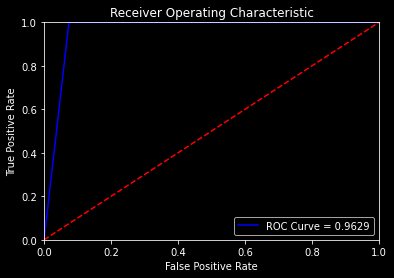

<Figure size 7200x7200 with 0 Axes>

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred_acc)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'ROC Curve = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.figure(figsize=(100, 100))
plt.show()

# Support Vector Machine


Support Vector Machine is a supervised machine learning algorithm also used for classification and regression. In our case we will use this algorithm for classification following the same logic as the KNN . 

For SVM algorithm there are 3 important parameters in which we wll focus our model. In this case we choose smaller values for C from 0.001 to 10 allowing the model degree of freedom. This decision come from the computational expense of using high levels of C. 

Gamma is only used with the RBF kernel, it allows for more curvature. Having a large data set we will allow for some degree of curvature, however it comer with the expense of misslabelling 

In [ ]:
from sklearn.svm import SVC
my_SVC = SVC(probability=True)

In [ ]:
parameteres_sv = {'C':[0.001,0.1,1,10], 'gamma':[10,5,1,0.1,0.01], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [ ]:
my_svm_model = GridSearchCV(my_SVC, param_grid = parameteres_sv,scoring = 'roc_auc', cv=10, verbose=3,n_jobs=-1)

In [ ]:
my_svm_model.fit(x_s,y_s)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 8/10] END .C=0.001, gamma=10, kernel=linear;, score=0.952 total time=  11.0s
[CV 3/10] END .C=0.001, gamma=10, kernel=linear;, score=0.946 total time=  11.1s
[CV 1/10] END .C=0.001, gamma=10, kernel=linear;, score=0.945 total time=  11.1s
[CV 6/10] END .C=0.001, gamma=10, kernel=linear;, score=0.954 total time=  11.1s
[CV 2/10] END .C=0.001, gamma=10, kernel=linear;, score=0.954 total time=  11.2s
[CV 4/10] END .C=0.001, gamma=10, kernel=linear;, score=0.967 total time=  11.2s
[CV 7/10] END .C=0.001, gamma=10, kernel=linear;, score=0.975 total time=  11.2s
[CV 5/10] END .C=0.001, gamma=10, kernel=linear;, score=0.962 total time=  11.2s
[CV 9/10] END .C=0.001, gamma=10, kernel=linear;, score=0.947 total time=  12.0s
[CV 10/10] END C=0.001, gamma=10, kernel=linear;, score=0.973 total time=  12.2s
[CV 1/10] END ...C=0.001, gamma=10, kernel=poly;, score=0.874 total time=  15.9s
[CV 6/10] END ...C=0.001, gamma=10, kernel=pol

GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10],
                         'gamma': [10, 5, 1, 0.1, 0.01],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=3)

The model selected throught the GridSearch algorithm is a RBF kernel with a Cost parameter of 1, the fact that the GridSearch found the best score with a cost of 1. Tells us that no higher values of C needed to be tested. 

In [ ]:
print(my_svm_model.best_estimator_.C)
print(my_svm_model.best_estimator_.gamma)
print(my_svm_model.best_estimator_.kernel)
print(my_svm_model.best_score_)

1
0.01
rbf
0.9591016548463358


In [ ]:
ypred_svm=my_svm_model.predict(data_test_s)
ypred_svm_proba=my_svm_model.predict_proba(data_test_s)

In [ ]:
kaggle_test = data_test[['icustay_id']].astype(int)
kaggle_test['HOSPITAL_EXPIRE_FLAG'] = ypred_svm_proba[:,1]
kaggle_test['HOSPITAL_EXPIRE_FLAG'] = kaggle_test['HOSPITAL_EXPIRE_FLAG'] .apply(reweight,args=(q1,r1))
kaggle_test.head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.010033
1,251754,0.041747
2,242171,0.001998
3,263035,0.422755
4,279388,0.007794


# Assesing the model
To assess the model we will use the same valuation metrics from the sklearn module that we used in the KNN model. In order to access the model we will construct a test and train set from the original data_train.

In [ ]:
insample_y_pred_acc_svm = my_svm_model.predict(X_train)

# Compute different Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

print('Accuracy Score : ' + str(accuracy_score(y_train,insample_y_pred_acc_svm)))
print('Precision Score : ' + str(precision_score(y_train,insample_y_pred_acc_svm)))
print('Recall Score : ' + str(recall_score(y_train,insample_y_pred_acc_svm)))
print('F1 Score : ' + str(f1_score(y_train,insample_y_pred_acc_svm)))

Accuracy Score : 0.894720040860627
Precision Score : 0.5123809523809524
Recall Score : 0.9345686160972785
F1 Score : 0.6618823046955096


In [ ]:
y_pred_acc_svm = my_model.predict(X_test)

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_svm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_svm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_svm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_svm)))

Accuracy Score : 0.9345078513979318
Precision Score : 0.64375
Recall Score : 1.0
F1 Score : 0.7832699619771863


The results are pretty similar to the KNN model. However, it has a higher F1 score meaning that pur model has a probability of predicting a correct result of 0.7832.

## ROC AUC

Similar to the KNN the AUC is close to 1, indicating that our model is competent in predictiing a binary classfication

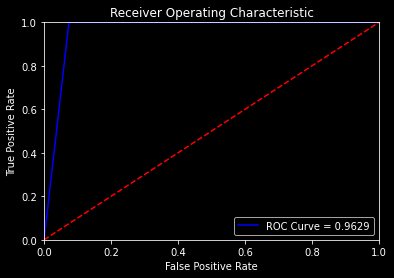

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred_acc_svm)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'ROC Curve = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()